In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import learning_curve

### Load saved dataframe

In [2]:
df = pd.read_pickle('data.pkl')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          

In [4]:
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nationality,Mother_qualification,Father_qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [5]:
# Step 1: Prepare the Data
X = df.drop(columns=['Target'])  # Features
y = df['Target']  # Target variable

In [6]:
# Step 2: Convert Target Variable to Numeric Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display the encoded labels and classes
print("Encoded Labels:", y_encoded)
print("Classes:", label_encoder.classes_)

Encoded Labels: [0 2 0 ... 0 2 2]
Classes: ['Dropout' 'Enrolled' 'Graduate']


In [7]:
y_encoded

array([0, 2, 0, ..., 0, 2, 2])

In [8]:
# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 4: Identify Numerical Columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()


In [9]:
# Step 5: Create a Column Transformer for Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', 'passthrough', categorical_cols)
    ]
)

# Step 6: Define Hyperparameter Search Spaces
rf_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__bootstrap': [True, False]
}

xgb_param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [1, 2, 3],
    'model__learning_rate': [0.02, 0.2, 0.4],
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 1.0]
}

In [10]:
# Step 7: Create Pipelines
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='mlogloss', random_state=42))
])

In [11]:
# # Perform hyperparameter tuning with RandomizedSearchCV to the RandomForest pipeline
rf_random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# # Perform hyperparameter tuning with RandomizedSearchCV to the XGBoost pipeline
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_param_dist,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_iter=10,
    n_jobs=-1,
    verbose=1,
    random_state=42
)


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   category
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   category
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Nationality                                     4424 non-null   category
 8   Mother_qualification                            4424 non-null   category
 9   Father_qualification          

In [13]:
# Using models without Hyperparameter tuning
rf_pipeline.fit(X_train, y_train)

# Predictions on the Test Set
rf_y_pred1 = rf_pipeline.predict(X_test)

In [14]:
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_y_pred1))
print(classification_report(y_test, rf_y_pred1))

Random Forest Test Accuracy: 0.7661016949152543
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       284
           1       0.53      0.33      0.40       159
           2       0.79      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.77      0.75       885



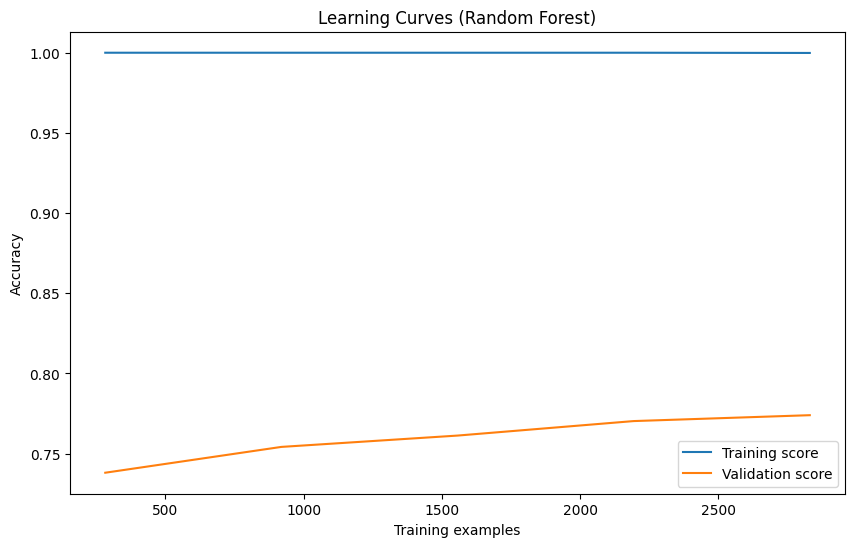

In [15]:
# Create learning curves for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rf_pipeline, X_train, y_train, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Validation score')
plt.title('Learning Curves (Random Forest)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Random Forest model shows perfect accuracy on the training data, its performance on the validation set indicates potential overfitting and little generalization.

In [16]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create the RFE object with the Random Forest model as the estimator
rfe = RFE(estimator=rf_model, n_features_to_select=25)  

# Fit RFE
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)


Selected Features: Index(['Application mode', 'Application order', 'Course',
       'Previous qualification (grade)', 'Mother_qualification',
       'Father_qualification', 'Mother_occupation', 'Father_occupation',
       'Admission grade', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'Unemployment rate',
       'Inflation rate', 'GDP'],
      dtype='object')


In [17]:
# Train model with selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict with test set
y_pred_rfe = rf_model.predict(X_test[selected_features])

# Evaluate the model
print("Random Forest Test Accuracy with RFE:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))

Random Forest Test Accuracy with RFE: 0.7762711864406779
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       284
           1       0.59      0.40      0.48       159
           2       0.80      0.93      0.86       442

    accuracy                           0.78       885
   macro avg       0.73      0.69      0.70       885
weighted avg       0.76      0.78      0.76       885



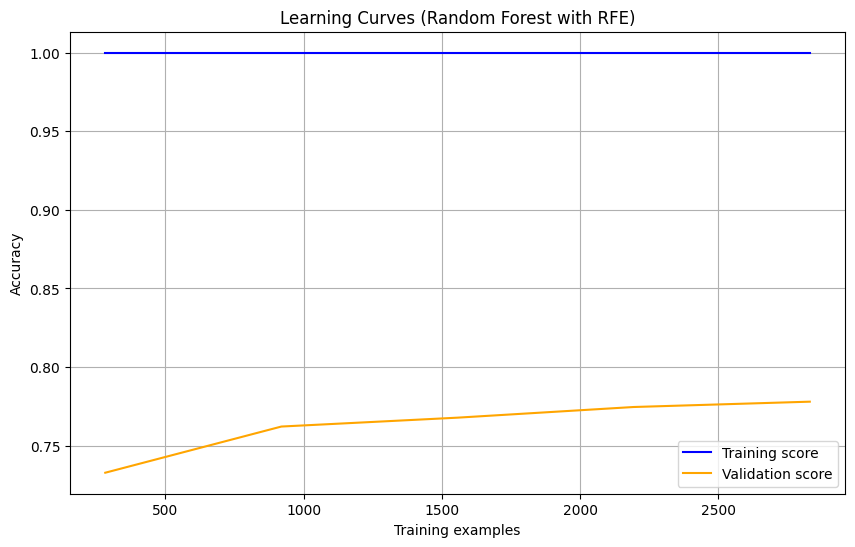

In [19]:
# Create learning curves for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rf_model, X_train[selected_features], y_train, cv=5, scoring='accuracy')

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validation score', color='orange')
plt.title('Learning Curves (Random Forest with RFE)')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Random Forest model shows perfect accuracy on the training data, its performance on the validation set indicates potential overfitting and slight improvement in generalization after features selection was done.

In [20]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Create the RFE object with the Random Forest model as the estimator
rfe = RFE(estimator=rf_model, n_features_to_select=15)  

# Fit RFE
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

print("Selected Features:", selected_features)


Selected Features: Index(['Course', 'Previous qualification (grade)', 'Mother_occupation',
       'Father_occupation', 'Admission grade', 'Tuition fees up to date',
       'Age at enrollment', 'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)', 'GDP'],
      dtype='object')


In [21]:
# Train model with selected features
rf_model.fit(X_train[selected_features], y_train)

# Predict with test set
y_pred_rfe = rf_model.predict(X_test[selected_features])

# Evaluate the model
print("Random Forest Test Accuracy with RFE:", accuracy_score(y_test, y_pred_rfe))
print(classification_report(y_test, y_pred_rfe))

Random Forest Test Accuracy with RFE: 0.7638418079096045
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       284
           1       0.54      0.36      0.43       159
           2       0.79      0.93      0.86       442

    accuracy                           0.76       885
   macro avg       0.71      0.67      0.68       885
weighted avg       0.75      0.76      0.75       885

